# Segmentation trial acquisitions (calcium imaging)
* Segmentation of (motion corrected) images


In [6]:
# 03_segment_lm_trials.ipynb

import os
import glob
import numpy as np
import napari

from tifffile import imwrite, imread
from scripts.sample_db import SampleDB
from cellpose import models, io
import skimage.exposure

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)

In [ ]:
# Load experiment
sample_id = '20220118_RM0012_124hpf_fP8_f2'  # Replace with your sample ID
exp = sample_db.get_sample(sample_id)
print(f"Processing sample: {exp.sample.id}")

# Import model
model_path = r'D:\montruth\cellpose\models\CP_20230803_101131'
model = models.CellposeModel(model_type=model_path, gpu=True)

# Making shortcuts of sample parameters/information
root_path = exp.paths.root_path
trials_path = exp.paths.trials_path
n_planes = exp.params_lm.n_planes
doubling = 2 if exp.params_lm.doubling else 1

# Get the path for the preprocessed folder and the images stack
processed_folder = os.path.join(trials_path, 'processed')
images_path = glob.glob(os.path.join(processed_folder, 'sum_elastic_*.tif'))[0]
images_stack = io.imread(images_path)

# Preprocess images
images_stack_rescaled = skimage.exposure.rescale_intensity(images_stack, out_range=(0, 1))
images_stack_clahe = skimage.exposure.equalize_adapthist(images_stack_rescaled)
images_stack = images_stack_clahe

# Define the path for the masks folder
masks_folder = os.path.join(trials_path, "masks")
os.makedirs(masks_folder, exist_ok=True)

# Define parameters for cellpose
cellprob_threshold = -3
flow_threshold = 0
resample = True
augment = False
stitch_threshold = 0.01

# Prepare the output array
masks_stack = np.empty(images_stack.shape, dtype=np.uint16)

# Loop through each plane and process images
for plane in range(n_planes * doubling):
    print(f"Processing plane: {plane}")
    images = images_stack[plane]

    # Segment the images using Cellpose
    masks, _, _ = model.eval(images,
                             channels=[0, 0],
                             cellprob_threshold=cellprob_threshold,
                             flow_threshold=flow_threshold,
                             resample=resample,
                             augment=augment,
                             stitch_threshold=stitch_threshold)

    # Store the masks
    masks_stack[plane] = masks

# Save masks
params_text = f"cp_{cellprob_threshold}-ft_{flow_threshold}-st_{stitch_threshold}-resample_{resample}-augment_{augment}"
imwrite(os.path.join(masks_folder, f'masks_{exp.sample.id}_{params_text}.tif'), masks_stack)

# Display results in Napari
viewer = napari.Viewer()
viewer.add_image(images_stack, name='Original')
viewer.add_labels(masks_stack, name='Segmentation')
napari.run()

# Update the sample database
sample_db.update_sample_field(sample_id, '03_segment_lm_trials', True)
sample_db.save(db_path)


print(f"Segmentation completed for sample: {exp.sample.id}")

TypeError: Invalid shape (24, 256, 512) for image data

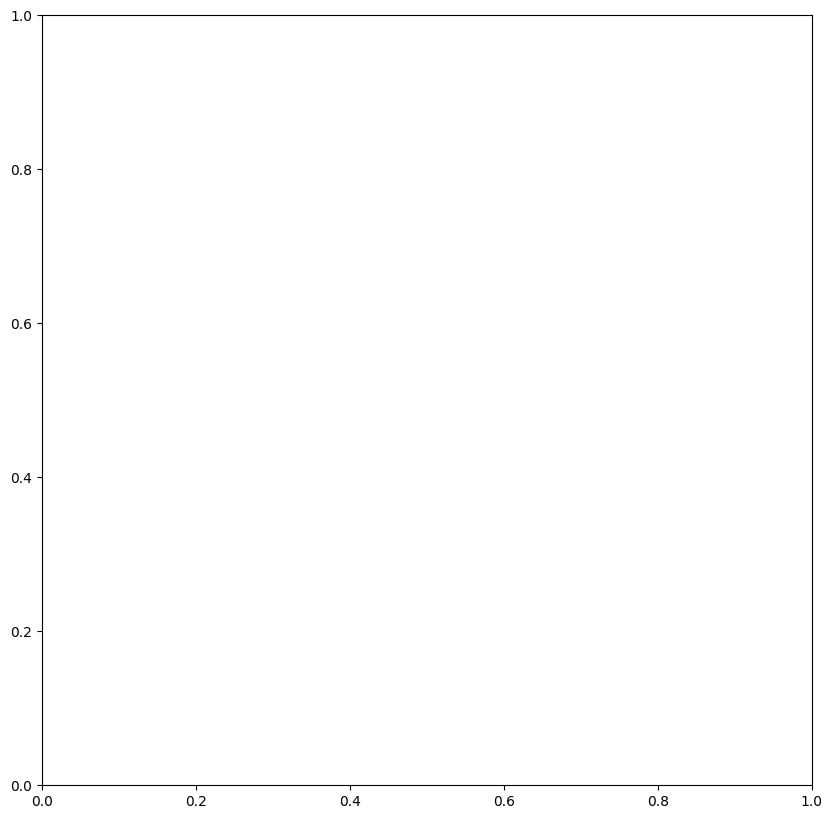